<a href="https://colab.research.google.com/github/atobefan/ucb/blob/master/FDR_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.stats


In [0]:
normal_distribution = scipy.stats.norm(loc=0,scale=1)

In [0]:
def benjamini_hochberg(p_values, alpha):
    # returns decisions: a binary vector of the same length as p-values, 
    # where decisions[i] is 1 if p_values[i] is deemed significant at level alpha, and 0 otherwize
    
    n = len(p_values)
    
    # get the idxs which will sorted the p-values in ascending order
    sorted_idxs = np.argsort(p_values)
    sorted_p_values = p_values[sorted_idxs]
    # find the largest k for which p_values[k] < k/n * alpha
    
    #  instantiate vector for k/n * alpha
    comparison = np.arange(1, n+1) * alpha / n
    
    # find the largest k such that p value falls below the comparison line
    # add one for zero indexing
    k = np.argmax(np.where(sorted_p_values <= comparison))
    
    # declare a discovery for anything with p-value <= the k^th p-value
    p_k = sorted_p_values[k]
    
    # instantiate decisions
    decisions = (p_values <= p_k).astype(int)
    
    # return decisions
    return decisions

In [0]:
  z =[]
  for w in range(len(mu)):
    z_values = np.random.normal(loc=mu[w], scale=1.0)
    z.append(z_values)
    p_values = 1-normal_distribution.cdf(z)
  predict=[1 if p_values[i-1]/(2*w/501) <=(alpha/500) else 0 for w in range(1,501)]


500

In [0]:
def classic_decision(p_vals, alpha):
    n = len(p_vals)
    decisions = np.array(p_vals) <= np.array([alpha]*n)
    return list(decisions)

def bonferroni_decision(p_vals, alpha):
    n = len(p_vals)
    alphas = [alpha/n]*n
    decisions = [p_vals[i] <= alphas[i] for i in range(n)]
    return decisions

def benjamin_Hochberg_decision(p_vals, alpha):
    n = len(p_vals)
    sorted_p = sorted(p_vals)
    K_map = {sorted_p[k-1]: k for k in range(1,n+1)}
    alphas = list((alpha/n)*np.arange(1, n+1))
    decisions = [sorted_p[i] <= alphas[i] for i in range(n)]

    try:
        K = n - decisions[::-1].index(True)
        decisions = [True if K_map[p] <= K else False for p in p_vals]
    except:
        decisions = [False]*n
    return decisions

def weighted_procedure(p_vals, alpha, w):
    #w is a function is a function of i
    decisions = []
    n = len(p_vals)
    Ws = np.array([w(i) for i in range(1, n+1)])
    sig = alpha/n*Ws
    for i in range(n):
        s = sig[i]
        if s == 0:
            decisions.append(False)
        else:
            decisions.append(p_vals[i] <= s)
    return decisions
def truth_table(actual, decisions):
    n = len(decisions)
    num_rej = sum(decisions)
    rej_true = sum([actual[i] and decisions[i] for i in range(n)])
    rej_false = num_rej - rej_true
    if num_rej == 0:
        FDR = 0
    else:
        FDR = rej_false/num_rej
    
    return num_rej, rej_true, rej_false, FDR



In [0]:
def mvNorm_sample(mu, C):
    ## Takes one sample from desired MV Normal distribution and returns p-vals
    z_s = -(np.random.multivariate_normal(mu, C))
    p_vals = scipy.stats.norm.cdf(z_s)
    return p_vals


In [0]:
def experiments1(mu, C, alphas, true_H1, decision_fn, N = 100):
    results = {"Total Rejections":[], "True Rejections":[], "False Rejections":[], "FDR":[]}
    for alpha in alphas: #for each alpha, do N experiments
        n_rej, n_tr, n_fr, FDRs = [], [], [], []
        for _ in range(N): #sample 100 times
            p_values = mvNorm_sample(mu, C)
            decisions = decision_fn(p_values, alpha)
            num_rej, rej_true, rej_false, FDR = truth_table(true_H1, decisions)
            n_rej.append(num_rej)
            n_tr.append(rej_true)
            n_fr.append(rej_false)
            FDRs.append(FDR)
            
        results["Total Rejections"].append(np.mean(n_rej))
        results["True Rejections"].append(np.mean(n_tr))
        results["False Rejections"].append(np.mean(n_fr))
        results["FDR"].append(np.mean(FDRs))
    return results

def experiments_weighted(mu, C, alphas, true_H1, decision_fn, w_fn, N = 100):
    results = {"Total Rejections":[], "True Rejections":[], "False Rejections":[], "FDR":[]}
    for alpha in alphas: #for each alpha, do N experiments
        n_rej, n_tr, n_fr, FDRs = [], [], [], []
        for _ in range(N): #sample 100 times
            p_values = mvNorm_sample(mu, C)
            decisions = decision_fn(p_values, alpha, w_fn)
            num_rej, rej_true, rej_false, FDR = truth_table(true_H1, decisions)
            n_rej.append(num_rej)
            n_tr.append(rej_true)
            n_fr.append(rej_false)
            FDRs.append(FDR)
        results["Total Rejections"].append(np.mean(n_rej))
        results["True Rejections"].append(np.mean(n_tr))
        results["FDR"].append(np.mean(FDRs))
    return results

In [0]:
mu = [0 if i <= 450 else (i-450)/5.0 for i in range(1,501)]
C = np.identity(500)
true_H1 = list(np.array(mu) != 0)

In [0]:
N = 100
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
classic = experiments1(mu, C, alphas, true_H1, classic_decision)


In [0]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
bonferroni = experiments1(mu, C, alphas, true_H1, bonferroni_decision)


In [0]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
benjamini= experiments1(mu, C, alphas, true_H1, benjamin_Hochberg_decision)

In [0]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
w1_fn = lambda i: 2*i/501
iv = experiments_weighted(mu, C, alphas, true_H1, weighted_procedure, w1_fn)


{'FDR': [0.0,
  0.0,
  0.00030303030303030303,
  0.0005798319327731092,
  0.0016869558030548743,
  0.002770852225011817,
  0.008786552976955454,
  0.01060758373451872,
  0.010755461071250543],
 'False Rejections': [0.0, 0.0, 0.01, 0.02, 0.06, 0.1, 0.32, 0.39, 0.4],
 'Total Rejections': [28.25,
  30.02,
  30.86,
  32.69,
  33.63,
  34.94,
  35.55,
  36.02,
  36.32],
 'True Rejections': [28.25,
  30.02,
  30.85,
  32.67,
  33.57,
  34.84,
  35.23,
  35.63,
  35.92]}

In [0]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
w2_fn = lambda i: 2*(501-i)/501
v = experiments_weighted(mu, C, alphas, true_H1, weighted_procedure, w2_fn)

In [0]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
w3_fn = lambda i: 0.5 if ((i<=450) and (i>=1)) else 5.5
vi = experiments_weighted(mu, C, alphas, true_H1, weighted_procedure, w3_fn)

In [0]:
def plot(results, attribute, labels):
    n = len(labels)
#     plt.figure(figsize = (15,15), dpi = 500)
    for i in range(n):
        dictionary = results[i]
        plt.plot(pi, dictionary[attribute], label = labels[i])
        plt.title("Average " + attribute)
    plt.legend()
    plt.show()

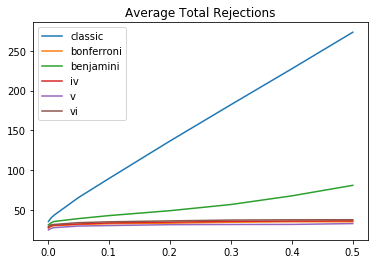

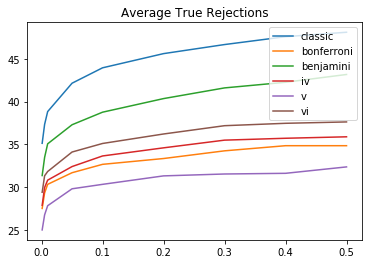

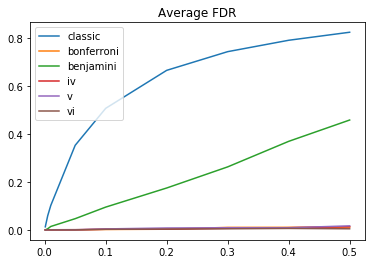

In [0]:
labels = ["classic", "bonferroni", "benjamini", "iv", "v", "vi"]
results = [classic, bonferroni, benjamini, iv, v, vi]

plot(results, "Total Rejections", labels)
plot(results, "True Rejections", labels)
plot(results, "FDR", labels)

In [0]:
import math
def LORD(stream,alpha):
    # Inputs: stream - array of p-values, alpha - target FDR level
    # Output: array of indices k such that the k-th p-value corresponds to a discovery
    
    gamma = lambda t: 6/(math.pi*t)**2
    w_0 = alpha/2
    n = len(stream)
    rejections = []
    alpha_t = gamma(1)*w_0
    for t in range(1,n+1):
        # Offset by one since indexing by 1 for t
        p_t = stream[t-1] 
        
        if p_t < alpha_t:
            rejections.append(t)

        next_alpha_t = gamma(t+1)*w_0 + alpha*sum([gamma(t+1-rej) for rej in rejections])
        # Check if tau_1 exists
        if len(rejections)>0:
            next_alpha_t -= gamma(t+1-rejections[0])*w_0
        

        # Update alpha
        alpha_t = next_alpha_t
    # Shift rejections since the rejections are 1-indexed
    shifted_rej = [rej-1 for rej in rejections]
    return shifted_rej
  
def LORDD(stream,alpha):
    decision = [0]*len(stream)
    for i in LORD(stream,alpha):
      decision[i]=1
    return decision

In [0]:
def bonferroni_decision(p_vals, alpha):
    n = len(p_vals)
    alphas = [alpha/n]*n
    decisions = [p_vals[i] <= alphas[i] for i in range(n)]
    return decisions

(i) For every i ∈ {1,...,N}, generate θi ∼ Bern(1-π0). If θi = 0, the p-value Pi is null, and should be generated from Unif[0, 1]. If θi = 1, the p-value Pi is an alternative. Then, generate Zi ∼ N (3, 1), and let Pi = Φ(−Zi), where Φ is the standard Gaussian N(0,1) CDF.



In [0]:
def p_values_1(pi0):
  p_values=[]
  theta = []
  for i in range(1,1001):
    thetai = np.random.binomial(n=1, p= 1-pi0)
    theta.append(thetai)
    if thetai==0:
      pvi = np.random.uniform(0,1)
    else:
      zi=np.random.normal(loc=3, scale=1.0)
      pvi = 1-normal_distribution.cdf(zi)
    p_values.append(pvi)
  
  return theta,p_values



(ii)For i = 1,...,π0N, set θi = 0, meaning the hypothesis is truly null, and let Pi ∼ Unif[0,1]. For i = π0N +1,...,N, θi = 1, and the hypothesis is truly alternative. Then, generate Zi ∼ N (3, 1), and let Pi = Φ(−Zi), where Φ is the standard Gaussian N(0,1) CDF.

In [0]:
def p_values_2(pi0):
  p_values=[]
  theta = []
  for i in range(1,int(pi0*1000)+1):
    thetai = 0
    theta.append(thetai)
    pvi = np.random.uniform(0,1)
    p_values.append(pvi)
  for j in range(int(pi0*1000)+1,1001):
    thetai = 1
    theta.append(thetai)
    zi=np.random.normal(loc=3, scale=1.0)
    pvj = 1-normal_distribution.cdf(zi)
    p_values.append(pvj)
  return theta, p_values

In [0]:
def p_values_3(pi0):
  p_values=[]
  theta = []
  for i in range(1,1000-int(pi0*1000)+1):
    thetai = 1
    theta.append(thetai)
    zi=np.random.normal(loc=3, scale=1.0)
    pvi = 1-normal_distribution.cdf(zi)
    p_values.append(pvi)
  for j in range(1000-int(pi0*1000)+1,1001):
    thetai = 0
    theta.append(thetai)
    pvj = np.random.uniform(0,1)
    p_values.append(pvj)
  return theta,p_values


In [0]:
def truth_table(actual, decisions):
    n = len(decisions)
    num_rej = sum(decisions)
    real_1 = sum(actual)
    rej_true = sum([actual[i] and decisions[i] for i in range(n)])
    rej_false = num_rej - rej_true
    sen = rej_true/real_1
    if num_rej == 0:
        FDR = 0
    else:
        FDR = rej_false/num_rej
    
    return num_rej, rej_true, rej_false, FDR, sen



In [0]:
def experiments( pv_func, decision_fn, alpha, pi, N = 100):
    results = {"Total Rejections":[], "True Rejections":[], "False Rejections":[], "FDR":[],"Sensitivity":[]}
    for i in pi: #for each pi, do N experiments
        n_rej, n_tr, n_fr, FDRs, Sens = [], [], [], [],[]
        for _ in range(N): #sample 100 times
            true_H1,p_values = pv_func(i)
            decisions = decision_fn(p_values, alpha)
            num_rej, rej_true, rej_false, FDR, sen = truth_table(true_H1, decisions)
            n_rej.append(num_rej)
            n_tr.append(rej_true)
            n_fr.append(rej_false)
            FDRs.append(FDR)
            Sens.append(sen)
            
            
        results["Total Rejections"].append(np.mean(n_rej))
        results["True Rejections"].append(np.mean(n_tr))
        results["False Rejections"].append(np.mean(n_fr))
        results["FDR"].append(np.mean(FDRs))
        results["Sensitivity"].append(np.mean(Sens))
    return results

In [0]:

pi = [0.1, 0.3, 0.5, 0.7, 0.9]
lord_1 = experiments(p_values_1, LORDD, 0.05, pi, N = 100)


In [0]:
lord_1

{'FDR': [0.004663315563695188,
  0.015293539711668242,
  0.02506790202719744,
  0.03567764457336962,
  0.032599517273641195],
 'False Rejections': [3.71, 8.99, 9.73, 6.76, 0.8],
 'Sensitivity': [0.879776082861962,
  0.8308742725522541,
  0.7559610205503877,
  0.6031824762878837,
  0.17826909377437797],
 'Total Rejections': [795.18, 587.5, 387.63, 188.4, 19.03],
 'True Rejections': [791.47, 578.51, 377.9, 181.64, 18.23]}

In [0]:
pi = [0.1, 0.3, 0.5, 0.7, 0.9]
lord_2 = experiments(p_values_2, LORDD, 0.05, pi, N = 100)


In [0]:
lord_2

{'FDR': [5.167244324106411e-05,
  3.341969779882291e-05,
  4.860025412663001e-05,
  0.00011695906432748537,
  0.0002197802197802198],
 'False Rejections': [0.04, 0.02, 0.02, 0.02, 0.02],
 'Sensitivity': [0.8762777777777778,
  0.8085571428571429,
  0.70062,
  0.5338333333333334,
  0.2104],
 'Total Rejections': [788.65, 565.99, 350.31, 160.15, 21.04],
 'True Rejections': [788.61, 565.97, 350.29, 160.13, 21.02]}

In [0]:
lord_3 = experiments(p_values_3, LORDD, 0.05, pi, N = 100)

In [0]:
lord_3

{'FDR': [0.00019917912525863648,
  0.0003327801506355237,
  0.0005085746931283311,
  0.0010017419531408462,
  0.0029961464592119214],
 'False Rejections': [0.16, 0.21, 0.23, 0.27, 0.27],
 'Sensitivity': [0.8967444444444445,
  0.898842857142857,
  0.89768,
  0.8976666666666666,
  0.8964000000000002],
 'Total Rejections': [807.07, 629.19, 448.84, 269.3, 89.64],
 'True Rejections': [806.91, 628.98, 448.61, 269.03, 89.37]}

In [0]:
bh_1 = experiments(p_values_1,benjamin_Hochberg_decision, 0.05, pi, N = 100)


In [0]:
bh_1

{'FDR': [0.005285305964345028,
  0.015227013843950256,
  0.025846582510414117,
  0.034355591019130244,
  0.04683605174560042],
 'False Rejections': [4.27, 9.44, 11.18, 8.32, 2.94],
 'Sensitivity': [0.8947446993528366,
  0.8719555538091709,
  0.8355674943823849,
  0.7709420912597063,
  0.5958429007666431],
 'Total Rejections': [808.64, 619.68, 430.7, 240.82, 61.74],
 'True Rejections': [804.37, 610.24, 419.52, 232.5, 58.8]}

In [0]:
bh_2 = experiments(p_values_2,benjamin_Hochberg_decision, 0.05, pi, N = 100)

In [0]:
bh_2

{'FDR': [0.005079609687907346,
  0.015377773971760931,
  0.024247354744791925,
  0.035404805005358406,
  0.046098012456050406],
 'False Rejections': [4.11, 9.57, 10.38, 8.55, 2.94],
 'Sensitivity': [0.8929333333333334,
  0.8733571428571429,
  0.83256,
  0.7729666666666666,
  0.6021],
 'Total Rejections': [807.75, 620.92, 426.66, 240.44, 63.15],
 'True Rejections': [803.64, 611.35, 416.28, 231.89, 60.21]}

In [0]:
bh_3 = experiments(p_values_3,benjamin_Hochberg_decision, 0.05, pi, N = 100)
bh_3

{'FDR': [0.005019379571246461,
  0.01541104262463363,
  0.024545161941060916,
  0.03528954887208152,
  0.0442890694048149],
 'False Rejections': [4.08, 9.55, 10.56, 8.52, 2.9],
 'Sensitivity': [0.8969888888888888,
  0.8695142857142857,
  0.8354599999999999,
  0.7716333333333333,
  0.6126999999999999],
 'Total Rejections': [811.37, 618.21, 428.29, 240.01, 64.17],
 'True Rejections': [807.29, 608.66, 417.73, 231.49, 61.27]}

In [0]:
def plot(results, attribute, labels):
    n = len(labels)
#     plt.figure(figsize = (15,15), dpi = 500)
    for i in range(n):
        dictionary = results[i]
        plt.plot(pi, dictionary[attribute], label = labels[i])
        plt.title("Average " + attribute)
    plt.legend()
    plt.show()

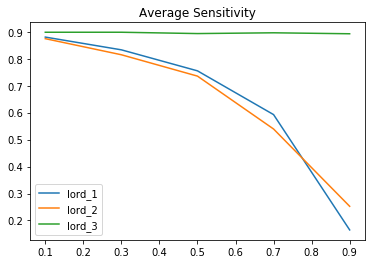

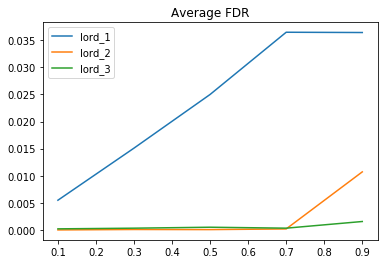

In [0]:
labels = ["lord_1","lord_2","lord_3"]
results = [lord_1,lord_2,lord_3]






plot(results, "Sensitivity", labels)
plot(results, "FDR", labels)

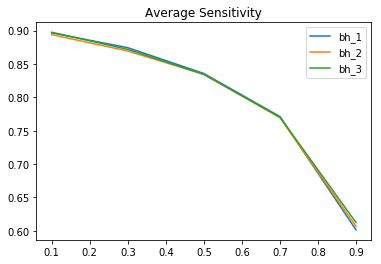

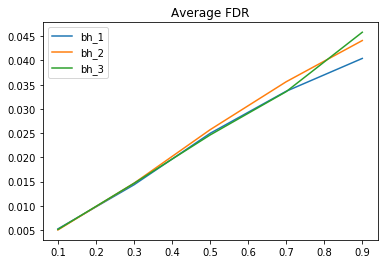

In [0]:
labels = ["bh_1","bh_2","bh_3"]
results = [bh_1,bh_2,bh_3]


plot(results, "Sensitivity", labels)
plot(results, "FDR", labels)

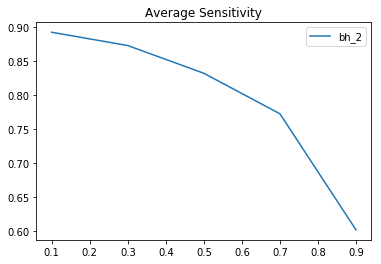

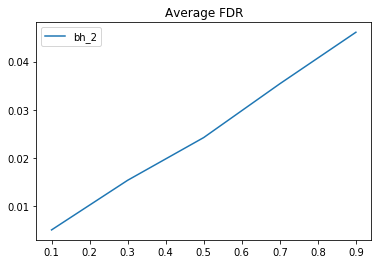

In [0]:
labels = ["bh_2"]
results = [bh_2]


plot(results, "Sensitivity", labels)
plot(results, "FDR", labels)

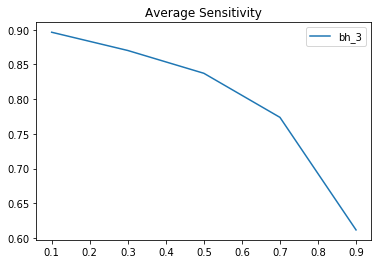

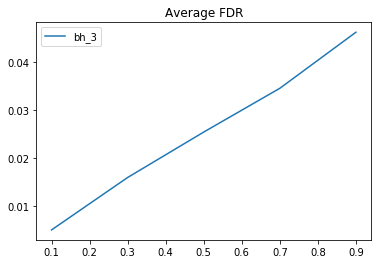

In [0]:
labels = ["bh_3"]
results = [bh_3]


plot(results, "Sensitivity", labels)
plot(results, "FDR", labels)

In [0]:
pi = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
